# Predicting lung cancer survival time 
## Owkin Challenge

The goal of this study if to predict a patient's survival time to lung cancer at a given time (given several features extracted from CT-scans). Due to the lack of time I will use directly the features extracted from the CT-scans and therefore not use the actual images.

To do this we will create and train a model on a dataset composed of two sub-sets. Our training set is composed of 300 patients, for each we have a set of 53 radiomics features (extracted from the CT-scans) and 6 clinical features (TNM staging, histology, age and source dataset). The target data (which we want to predict) is the time to event variable that corresponds to the survival time if the patient died during the study (event = 1) or the amount of time after which the patient escaped the study (event = 0).

I first opened the csv files to see there format and saw that the headers of the radiomics files were comprised of one blank line that had to remove (copy/paste 'PatientID' in the header line and remove the extra line) in order to get proper header when importing the data.

In [525]:
import pandas as pd
pd.options.display.max_rows = 20
pd.options.display.max_columns = 55
pd.options.display.float_format = '{:.1f}'.format

radiomics_train_ini = pd.read_csv('D:/Owkin_challenge/data_xtrain/features/radiomics.csv', index_col=0, header=1)
clinical_train_ini = pd.read_csv('D:/Owkin_challenge/data_xtrain/features/clinical_data.csv', index_col=0)
output_train_ini = pd.read_csv('D:/Owkin_challenge/output.csv', index_col=0)

Before getting started on the actual model I'm used to exploring a bit the data, to get familiar with it and start extracting some insight on our problem.

## Exploring the data

First let's check all the features available and the target data.

In [11]:
import matplotlib.pyplot as plt

print(output_train_ini.keys())
print(clinical_train_ini.keys())
print(radiomics_train_ini.keys())

Index(['SurvivalTime', 'Event'], dtype='object')
Index(['Histology', 'Mstage', 'Nstage', 'SourceDataset', 'Tstage', 'age'], dtype='object')
Index(['original_shape_Compactness1', 'original_shape_Compactness2',
       'original_shape_Maximum3DDiameter',
       'original_shape_SphericalDisproportion', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume', 'original_firstorder_Energy',
       'original_firstorder_Entropy', 'original_firstorder_Kurtosis',
       'original_firstorder_Maximum', 'original_firstorder_Mean',
       'original_firstorder_MeanAbsoluteDeviation',
       'original_firstorder_Median', 'original_firstorder_Minimum',
       'original_firstorder_Range', 'original_firstorder_RootMeanSquared',
       'original_firstorder_Skewness', 'original_firstorder_StandardDeviation',
       'original_firstorder_Uniformity', 'original_firstorder_Variance',
       'original_glcm_Autocorrelation', 'origi

I will start by working on the radiomics table. I will check that there are no missing data and if there are I will fill them with the mean value of the corresponding feature.

In [504]:
radiomics_train_ini.isnull().any().any()

False

There are no missing data.

Next I'll have a look on the data and see if normalization of the data would be needed (normalization can be necessary if different features have very different ranges because they would introduce inner differences in weight over the output).

In [26]:
radiomics_train_ini.describe()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
count,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0
mean,0.0,0.3,63.7,1.7,0.6,10269.3,0.3,55941.0,2725406582.2,4.2,8.9,400.5,-162.8,167.1,-113.7,-921.7,1322.2,282.1,-1.5,209.8,0.1,50747.8,1132.1,319654.0,-3534.4,265.0,30.6,0.8,3.0,3.2,0.0,7.3,0.5,0.4,-0.2,0.9,1.0,0.9,0.3,0.1,64.3,5.0,0.8,3.0,4028.9,21708.3,0.8,0.0,1053.3,0.0,842.4,0.0,3956.6
std,0.0,0.1,35.5,0.3,0.1,11020.9,0.2,82370.7,5094066848.6,0.9,13.5,398.9,161.0,83.9,192.1,102.3,432.3,153.5,1.6,82.2,0.1,36012.1,376.5,331814.6,5057.8,197.7,32.0,0.1,0.8,2.0,0.0,1.8,0.2,0.2,0.1,0.1,0.0,0.0,0.1,0.1,12.6,0.9,0.1,2.3,7354.2,30741.8,0.1,0.0,367.3,0.0,258.0,0.0,3721.3
min,0.0,0.0,13.5,1.2,0.3,409.7,0.1,640.0,23884613.0,2.2,1.4,-71.0,-665.6,26.8,-776.0,-1159.0,656.0,53.6,-8.2,49.5,0.0,2452.4,271.7,2271.2,-28739.7,10.9,1.2,0.4,1.3,0.5,0.0,3.6,0.2,0.1,-0.4,0.5,0.9,0.9,0.2,0.0,29.6,2.8,0.6,1.1,20.7,503.4,0.4,0.0,259.3,0.0,245.1,0.0,325.5
25%,0.0,0.2,33.9,1.4,0.6,2187.2,0.2,5586.8,543491683.0,3.5,2.2,143.0,-274.4,100.2,-205.5,-1011.0,1027.2,153.4,-2.3,146.5,0.0,21475.8,866.1,94694.1,-5644.8,108.3,8.5,0.7,2.4,1.6,0.0,6.0,0.3,0.3,-0.3,0.9,1.0,0.9,0.2,0.0,56.6,4.3,0.8,1.4,179.7,3594.1,0.7,0.0,790.9,0.0,657.4,0.0,1396.4
50%,0.0,0.2,57.8,1.6,0.6,5669.5,0.3,19523.0,1093244054.5,4.4,3.7,267.5,-123.7,163.3,-15.5,-952.0,1228.0,253.4,-1.1,212.8,0.1,45277.0,1144.7,227061.9,-2830.4,233.5,17.6,0.8,3.0,2.7,0.0,7.4,0.5,0.4,-0.2,0.9,1.0,1.0,0.3,0.1,64.8,5.1,0.9,2.2,891.6,10812.6,0.8,0.0,1048.2,0.0,850.1,0.0,2566.3
75%,0.0,0.3,82.9,1.8,0.7,14084.9,0.4,68332.2,2994063055.0,5.0,9.4,509.2,-34.4,226.9,20.0,-855.8,1498.0,398.8,-0.5,268.4,0.2,72022.5,1415.9,430586.5,-1017.1,385.1,38.8,0.9,3.7,4.5,0.1,8.8,0.6,0.6,-0.2,0.9,1.0,1.0,0.4,0.2,73.4,5.9,0.9,3.9,4138.1,28318.1,0.9,0.0,1323.5,0.0,1017.5,0.0,5583.5
max,0.0,0.6,216.7,3.2,0.9,67799.8,0.8,502660.0,51010160337.0,5.6,98.5,3068.0,70.7,372.0,75.0,-491.0,4055.0,723.1,2.0,416.3,0.4,173272.7,1972.7,2979372.6,34365.3,1025.8,156.0,1.0,4.6,9.0,0.3,10.4,0.8,0.8,-0.0,1.0,1.0,1.0,0.5,0.5,88.7,6.5,1.0,19.6,61727.6,267812.3,1.0,0.1,1960.1,0.1,1621.3,0.3,25570.6


The range of the values differs quite a lot (e.g. 'original_firstorder_Energy' as a mean of 2725406582.2 where 'original_shape_Compactness2' has a mean of 0.3). Normalizing the data will then help me have a set of features that are spread over even ranges without interfering with the distribution of values for each features. I need to keep the rescaling values in memory because I will need to apply the exact same rescaling method on the testing set before applying my model otherwise the results will be false.
I will apply a standardization so that each features are spread with a mean of 0 and a standard deviation of 1.

In [505]:
from sklearn import preprocessing

scaler_radiomics = preprocessing.StandardScaler().fit(radiomics_train_ini)
radiomics_train_norm = radiomics_train_ini.copy()
radiomics_train_norm[radiomics_train_norm.columns] = scaler_radiomics.transform(
    radiomics_train_ini[radiomics_train_ini.columns])

radiomics_train_norm.describe()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
count,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0
mean,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-2.7,-2.0,-1.4,-1.6,-3.0,-0.9,-1.4,-0.7,-0.5,-2.3,-0.6,-1.2,-3.1,-1.7,-3.5,-2.3,-1.5,-1.5,-4.3,-2.0,-1.0,-1.3,-2.3,-1.0,-5.0,-1.3,-0.9,-4.2,-2.2,-1.4,-0.9,-2.1,-1.7,-1.6,-3.4,-6.0,-4.0,-2.8,-2.0,-1.1,-2.8,-2.4,-3.0,-0.8,-0.5,-0.7,-2.5,-0.5,-2.2,-0.6,-2.3,-0.3,-1.0
25%,-0.7,-0.7,-0.8,-0.7,-0.6,-0.7,-0.8,-0.6,-0.4,-0.8,-0.5,-0.6,-0.7,-0.8,-0.5,-0.9,-0.7,-0.8,-0.5,-0.8,-0.9,-0.8,-0.7,-0.7,-0.4,-0.8,-0.7,-0.5,-0.8,-0.8,-0.8,-0.8,-0.9,-0.9,-0.7,-0.4,-0.6,-0.8,-0.8,-0.9,-0.6,-0.8,-0.8,-0.7,-0.5,-0.6,-0.8,-0.4,-0.7,-0.5,-0.7,-0.3,-0.7
50%,-0.0,-0.1,-0.2,-0.2,0.0,-0.4,-0.2,-0.4,-0.3,0.2,-0.4,-0.3,0.2,-0.0,0.5,-0.3,-0.2,-0.2,0.2,0.0,-0.3,-0.2,0.0,-0.3,0.1,-0.2,-0.4,0.2,0.0,-0.3,-0.4,0.1,-0.0,-0.0,-0.1,0.2,0.4,0.2,0.1,-0.2,0.0,0.1,0.2,-0.4,-0.4,-0.4,0.2,-0.3,-0.0,-0.3,0.0,-0.2,-0.4
75%,0.7,0.7,0.5,0.4,0.7,0.3,0.6,0.2,0.1,0.9,0.0,0.3,0.8,0.7,0.7,0.6,0.4,0.8,0.6,0.7,0.6,0.6,0.8,0.3,0.5,0.6,0.3,0.7,0.8,0.6,0.5,0.8,0.9,0.9,0.7,0.7,0.8,0.9,0.8,0.7,0.7,0.9,0.9,0.4,0.0,0.2,1.0,0.0,0.7,0.0,0.7,-0.1,0.4
max,2.7,3.5,4.3,4.8,2.5,5.2,3.0,5.4,9.5,1.5,6.6,6.7,1.5,2.4,1.0,4.2,6.3,2.9,2.2,2.5,3.8,3.4,2.2,8.0,7.5,3.9,3.9,1.6,2.0,2.9,6.4,1.7,2.0,2.0,2.8,1.7,1.0,1.5,2.0,5.1,1.9,1.6,1.3,7.3,7.9,8.0,1.4,11.1,2.5,10.0,3.0,10.9,5.8


My goal is now to select a sample of the radiomics features that hold information for the prediction of survival time. This is important because non-informative variables put noise in the model and can cause overfitting and decrease the prediction precision.
To do so I'll use filter methods to determine the correlation between a feature and our targeted survival time. Some of our data are censored, which mean that the time-to-event value that we get from them doesn't correspond to a time of death but to a time where the subject escaped the study. 

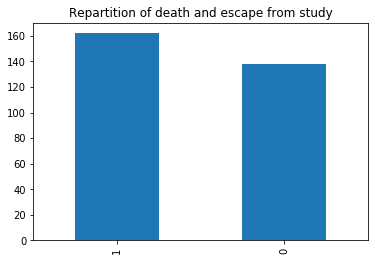

In [38]:
pd.value_counts(output_train_ini['Event']).plot.bar(title = "Repartition of death and escape from study")

Our dataset presents a huge part of censored data. For our correlation analysis to select relevant features we will drop the observation corresponding to censored data because the survival time doesn't have the same meaning.

In [62]:
target_uncensored = output_train_ini['SurvivalTime'][output_train_ini['Event'] == 1]
radiomics_uncensored = radiomics_train_norm[output_train_ini['Event'] == 1]

I will use the Pearson correlation coefficient on each of the feature to mesurate the correlation between this feature and the survival time.

In [191]:
pearson_table = pd.concat([radiomics_uncensored, target_uncensored], axis=1, sort=False).corr(method='pearson')
pearson_table

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,SurvivalTime
original_shape_Compactness1,1.0,1.0,-0.6,-1.0,1.0,-0.5,0.1,-0.3,-0.2,0.1,-0.2,-0.3,-0.1,0.0,-0.1,0.3,-0.4,0.0,0.1,-0.0,-0.1,-0.1,-0.4,-0.1,0.1,-0.1,-0.1,-0.1,0.1,0.0,-0.0,0.0,-0.1,-0.1,0.0,0.0,-0.2,-0.2,-0.1,0.0,-0.3,0.0,0.1,-0.0,-0.2,-0.4,0.1,0.0,-0.4,0.0,-0.4,0.0,-0.1,0.2
original_shape_Compactness2,1.0,1.0,-0.6,-0.9,1.0,-0.5,0.1,-0.3,-0.2,0.1,-0.2,-0.3,-0.1,0.0,-0.1,0.3,-0.4,0.0,0.1,-0.0,-0.1,-0.1,-0.4,-0.2,0.1,-0.1,-0.1,-0.1,0.1,0.0,-0.0,0.0,-0.1,-0.1,0.0,0.0,-0.2,-0.2,-0.2,0.0,-0.3,0.1,0.1,-0.0,-0.2,-0.4,0.1,0.0,-0.4,0.0,-0.4,-0.0,-0.1,0.2
original_shape_Maximum3DDiameter,-0.6,-0.6,1.0,0.6,-0.6,0.9,-0.6,0.8,0.4,-0.5,0.4,0.5,0.5,-0.4,0.5,-0.3,0.5,-0.4,-0.4,-0.3,0.5,-0.3,0.6,0.0,-0.2,-0.2,-0.4,0.4,-0.6,-0.5,0.4,-0.5,0.6,0.6,-0.4,-0.1,0.6,0.7,0.5,0.4,0.6,-0.5,-0.6,0.5,0.7,0.7,-0.6,-0.2,0.7,-0.3,0.5,-0.0,0.6,-0.3
original_shape_SphericalDisproportion,-1.0,-0.9,0.6,1.0,-1.0,0.5,-0.1,0.2,0.2,-0.0,0.1,0.3,0.1,-0.0,0.1,-0.3,0.4,-0.0,-0.1,0.0,0.0,0.1,0.4,0.1,-0.1,0.1,0.1,0.1,-0.0,-0.0,-0.0,-0.0,0.1,0.1,-0.0,-0.0,0.1,0.2,0.1,-0.0,0.3,-0.0,-0.1,0.0,0.2,0.3,-0.1,-0.0,0.4,-0.0,0.4,-0.0,0.1,-0.2
original_shape_Sphericity,1.0,1.0,-0.6,-1.0,1.0,-0.5,0.1,-0.3,-0.2,0.0,-0.2,-0.3,-0.1,0.0,-0.1,0.3,-0.4,0.0,0.1,-0.0,-0.1,-0.1,-0.4,-0.1,0.1,-0.1,-0.1,-0.1,0.1,0.0,-0.0,0.0,-0.1,-0.1,0.0,0.0,-0.1,-0.2,-0.1,0.0,-0.3,0.0,0.1,-0.0,-0.2,-0.4,0.1,0.0,-0.4,0.0,-0.4,0.0,-0.1,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
original_glrlm_ShortRunLowGrayLevelEmphasis,0.0,0.0,-0.3,-0.0,0.0,-0.3,0.4,-0.2,0.1,0.5,-0.2,-0.0,-0.6,0.6,-0.7,-0.0,-0.0,0.6,0.4,0.6,-0.4,0.7,-0.4,0.7,0.4,0.7,0.4,-0.0,0.4,0.5,-0.3,0.4,-0.4,-0.4,-0.0,0.2,-0.4,-0.4,-0.4,-0.4,-0.5,0.5,0.4,-0.3,-0.2,-0.2,0.4,1.0,-0.4,1.0,-0.3,0.8,-0.3,0.1
original_glrlm_ShortRunHighGrayLevelEmphasis,-0.4,-0.4,0.5,0.4,-0.4,0.6,-0.4,0.4,0.2,-0.2,0.3,0.4,0.5,-0.2,0.5,-0.7,0.5,-0.3,-0.4,-0.1,0.2,-0.1,0.9,0.1,-0.3,-0.1,-0.1,0.1,-0.2,-0.2,0.1,-0.2,0.2,0.2,0.0,-0.2,0.3,0.4,0.3,0.1,0.9,-0.2,-0.3,0.1,0.4,0.5,-0.2,-0.2,0.9,-0.3,1.0,-0.1,0.4,-0.1
original_glrlm_LongRunLowGrayLevelEmphasis,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.1,0.0,0.4,0.2,-0.1,0.0,-0.3,0.3,-0.3,-0.1,0.1,0.3,0.2,0.4,-0.1,0.5,-0.2,0.8,0.1,0.5,0.1,0.2,0.1,0.1,-0.1,0.1,-0.1,-0.1,-0.3,0.2,-0.0,-0.0,-0.1,-0.1,

In [196]:
idx_corr = pearson_table[np.abs(pearson_table.SurvivalTime) < 0.29].index
pearson_table_select = pearson_table.copy()
pearson_table_select = pearson_table_select.drop(index = idx_corr, columns = idx_corr).drop(columns='SurvivalTime', axis=1)
pearson_table_select

,original_shape_Maximum3DDiameter,original_shape_SurfaceArea,original_glcm_Contrast,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glrlm_ShortRunEmphasis,original_glrlm_RunPercentage
original_shape_Maximum3DDiameter,1.0,0.9,-0.4,-0.6,-0.5,-0.5,0.6,0.6,-0.4,0.6,0.7,0.5,-0.6,-0.6
original_shape_SurfaceArea,0.9,1.0,-0.4,-0.5,-0.5,-0.5,0.5,0.5,-0.3,0.6,0.6,0.5,-0.6,-0.6
original_glcm_Contrast,-0.4,-0.4,1.0,0.8,1.0,0.7,-0.8,-0.8,0.5,-0.9,-0.8,-0.8,0.7,0.7
original_glcm_DifferenceEntropy,-0.6,-0.5,0.8,1.0,1.0,1.0,-1.0,-1.0,0.5,-0.8,-0.9,-0.9,1.0,0.9
original_glcm_DifferenceAverage,-0.5,-0.5,1.0,1.0,1.0,0.9,-0.9,-0.9,0.5,-0.9,-0.9,-0.9,0.9,0.9
original_glcm_JointEntropy,-0.5,-0.5,0.7,1.0,0.9,1.0,-1.0,-1.0,0.4,-0.7,-0.8,-0.8,1.0,0.9
original_glcm_Id,0.6,0.5,-0.8,-1.0,-0.9,-1.0,1.0,1.0,-0.6,0.8,0.9,0.8,-1.0,-1.0
original_glcm_Idm,0.6,0.5,-0.8,-1.0,-0.9,-1.0,1.0,1.0,-0.5,0.8,0.9,0.8,-1.0,-1.0
original_glcm_Imc1,-0.4,-0.3,0.5,0.5,0.5,0.4,-0.6,-0.5,1.0,-0.5,-0.5,-0.3,0.5,0.6
original_glcm_Idmn,0.6,0.6,-0.9,-0.8,-0.9,-0.7,0.8,0.8,-0.5,1.0,1.0,0.8,-0.8,-0.8


By selecting only the features that have the strongest correlation (above 0.29 in absolute) with the survival time I would keep 14 of the 53 features for my model. Next I want to verify that the selected features don't bring redundant information. The features that we would keep differ from the features kept by the baseline model. 

I looked at the correlation table obtained by keeping the censored data (subjects that escaped the study) and some of the features of the baseline model appeared as the ones strongly correlated to the survival time. For my study of this problem I will rather keep the most correlated features when calculing it without the censored data because the correlation between the time one escapes the study doesn't have to be related to any radiomics parameter.

By looking at the correlation table above I see that some features are strongly correlated among themselves. Keeping all those features can maybe bring biais on the future model. I will then get rid of some features that seem strongly correlated with a lot of others. As a threshold I take that if a feature as a correlation very close to 1 or -1 with more than 4 features (not counting itself) I remove it from the set.

In [506]:
mask = np.sum(np.abs(pearson_table_select[np.abs(pearson_table_select)>0.95]))>=4.8
pearson_table_select = pearson_table_select.drop(index = mask[mask==True].index, columns = mask[mask==True].index)
pearson_table_select

,original_shape_Maximum3DDiameter,original_shape_SurfaceArea,original_glcm_Contrast,original_glcm_DifferenceAverage,original_glcm_Imc1,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glrlm_RunPercentage
original_shape_Maximum3DDiameter,1.0,0.9,-0.4,-0.5,-0.4,0.6,0.7,0.5,-0.6
original_shape_SurfaceArea,0.9,1.0,-0.4,-0.5,-0.3,0.6,0.6,0.5,-0.6
original_glcm_Contrast,-0.4,-0.4,1.0,1.0,0.5,-0.9,-0.8,-0.8,0.7
original_glcm_DifferenceAverage,-0.5,-0.5,1.0,1.0,0.5,-0.9,-0.9,-0.9,0.9
original_glcm_Imc1,-0.4,-0.3,0.5,0.5,1.0,-0.5,-0.5,-0.3,0.6
original_glcm_Idmn,0.6,0.6,-0.9,-0.9,-0.5,1.0,1.0,0.8,-0.8
original_glcm_Idn,0.7,0.6,-0.8,-0.9,-0.5,1.0,1.0,0.9,-0.9
original_glcm_InverseVariance,0.5,0.5,-0.8,-0.9,-0.3,0.8,0.9,1.0,-0.7
original_glrlm_RunPercentage,-0.6,-0.6,0.7,0.9,0.6,-0.8,-0.9,-0.7,1.0
SurvivalTime,-0.3,-0.3,0.3,0.3,0.3,-0.3,-0.3,-0.3,0.3


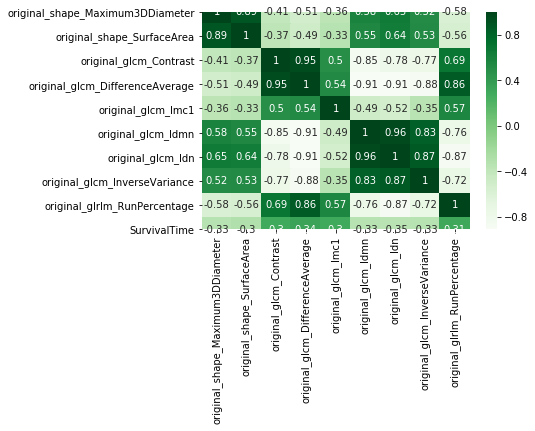

In [323]:
import seaborn as sns

sns.heatmap(pearson_table_select, annot=True, cmap=plt.cm.Greens)
plt.show()

That leaves me with a set of 9 radiomics features that I will try to work on.

After dealing with the radiomics features I will look at the clinical data. This table has 6 features: histology, NTM stages, source dataset and age. I will proceed the same way I did with the radiomics data, first checling for missing values.

In [507]:
radiomics_train = radiomics_train_norm[pearson_table_select.columns]

In [508]:
clinical_train_ini.isnull().any()

Histology         True
Mstage           False
Nstage           False
SourceDataset    False
Tstage           False
age               True
dtype: bool

There are some missing data on the histology and age features. 

The age is a numerical feature. I will then replace the missing values by the median value of the set and standardize it.
I will plot the bar graph of the histology categorical values count to check the categories repartition as well as the categories names.

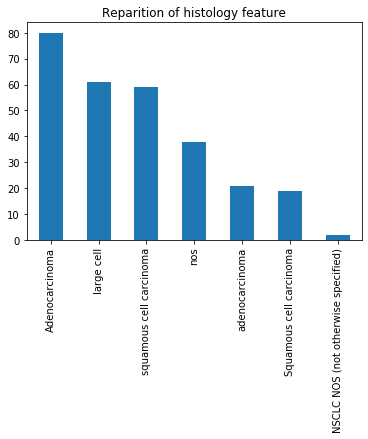

In [526]:
clinical_train_norm = clinical_train_ini.copy()
clinical_train_norm['age'] = clinical_train_norm.age.replace(
    np.NaN, np.median(clinical_train_ini['age'][~clinical_train_ini['age'].isnull()].values))
                      
scaler_age = preprocessing.StandardScaler().fit(clinical_train_norm['age'].values.reshape(-1, 1))

clinical_train_norm['age'] = scaler_age.transform(clinical_train_norm['age'].values.reshape(-1, 1))

pd.value_counts(clinical_train_norm['Histology']).plot.bar(title = "Reparition of histology feature")                 

Apart from the missing values there are also problems in the naming of the categories that are redundant. I will rename the categories to four labels: AC (adenocarcinoma), LC (large cell), SCC (squamous cell carcinoma) and nos (not otherwise specified). I will put the missing data in the last category.

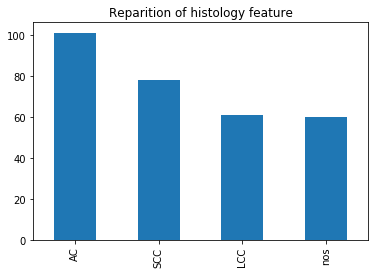

In [510]:
clinical_train_norm['Histology'] = clinical_train_ini['Histology'].replace(
    ['Adenocarcinoma','adenocarcinoma', 'NSCLC NOS (not otherwise specified)', 'Squamous cell carcinoma', 
     'squamous cell carcinoma', 'large cell', np.NaN], ['AC', 'AC', 'nos', 'SCC', 'SCC', 'LCC', 'nos'])
pd.value_counts(clinical_train_norm['Histology']).plot.bar(title = "Reparition of histology feature")

Now that the values are all well categorized and the missing data dealt with I can start selecting the feature I would keep in the prediction model. Let's extract uncensored data to test the features on.

In [ ]:
clinical_uncensored = clinical_train_norm.copy()
clinical_uncensored = clinical_train_norm[output_train_ini['Event'] == 1]

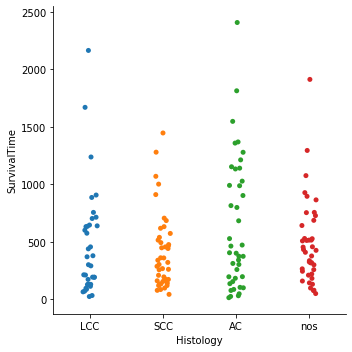

In [429]:
sns.catplot(x='Histology', y='SurvivalTime', 
            data = pd.concat([clinical_uncensored["Histology"],target_uncensored], axis=1, sort=False))

The histology of the tumor doesn't seem to give much information on the survival time seeing the repartition of dots on the above graph.

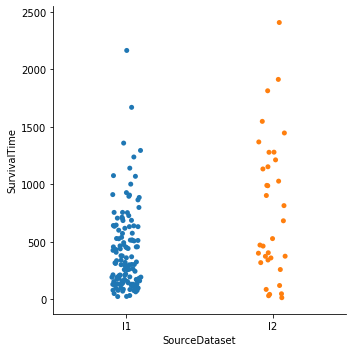

In [337]:
sns.catplot(x='SourceDataset', y='SurvivalTime', 
            data = pd.concat([clinical_uncensored["SourceDataset"],target_uncensored], axis=1))

The dataset labelled l1 seems more correlated with early deaths than the dataset labelled l2. This feature can thus be of importance in the prediction model.

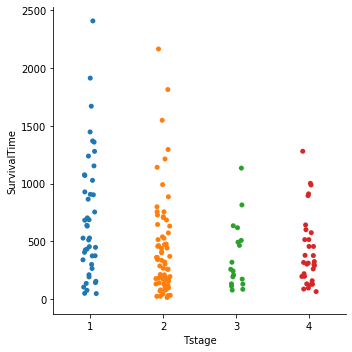

In [391]:
sns.catplot(x='Tstage', y='SurvivalTime', hue="Nstage",
            data = pd.concat([clinical_uncensored["Tstage"],clinical_uncensored["Nstage"],target_uncensored], axis=1))

For the feature Mstage, the majority of data is in the category 0, there is not enough variability among the data to use it as a predictor.
For the feature Tstage, it seems that the majority of dots for each categorical are towards reduced survival time but the further the stage (from 1 to 4) the thinner the range of data is. This could mean that this feature can be used for the prediction.
For the feature Nstage, even if the category 1 is not well representated it seems that the conclusion of correlation between value and survival time can be similar as the one made for Tstage.

When plotting the survival time depending on both Nstage and Tstage it doesn't appear that the two stages are much related together because dots representing one Tstage are found within all Nstage values. 

Keeping the features Tstage and Nstage in the model could thus be useful to predict survival time.

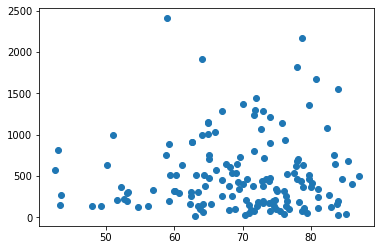

In [350]:
plt.scatter(clinical_train_ini['age'][output_train_ini['Event']==1], target_uncensored)

The age can be an insightful feature to add to the model.

From the clinical data 4 features are then kept. To create the model I will use a one-hot encoding on the categorical data to be sure that each values of the category have the same weight in the function.

In [356]:
clinical_train = clinical_train_norm[['SourceDataset', 'Nstage', 'Tstage', 'age']]
clinical_train = pd.get_dummies(clinical_train,prefix=['SourceDataset', 'Nstage', 'Tstage'], 
                                columns = ['SourceDataset', 'Nstage', 'Tstage'], drop_first=True)
features_train = pd.concat([radiomics_train, clinical_train], axis=1, sort=False)
features_train.head()

,original_shape_Maximum3DDiameter,original_shape_SurfaceArea,original_glcm_Contrast,original_glcm_DifferenceAverage,original_glcm_Imc1,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glrlm_RunPercentage,age,SourceDataset_l2,Nstage_1,Nstage_2,Nstage_3,Tstage_2,Tstage_3,Tstage_4,Tstage_5
PatientID,,,,,,,,,,,,,,,,,,
202,-0.4,-0.4,0.7,0.9,0.8,-0.7,-0.9,-0.8,0.9,-0.3,1,0,0,0,1,0,0,0
371,0.3,0.0,-0.4,-0.3,-0.4,0.4,0.3,0.3,-0.0,-0.5,0,0,1,0,0,0,1,0
246,0.2,0.0,-0.7,-0.9,-0.4,0.6,0.6,0.8,-0.9,-0.3,0,0,0,1,1,0,0,0
240,-0.5,-0.5,-0.5,-0.4,0.2,0.4,0.2,0.5,0.4,-1.0,0,0,1,0,0,1,0,0
284,-0.3,-0.5,-0.3,-0.4,-0.2,0.4,0.4,0.9,-0.3,0.2,0,0,0,1,0,0,1,0


Since all the preprocessing of the data I've done will need to be done again on the training input set I'll create a function now that I can use later.

In [873]:
def preprocessing_data(input_radiomics, input_clinical, radiomics_scaler, age_scaler, idx_col, 
                       idx_col_clini, separate_dataset=False):
    i_rad = input_radiomics.copy()
    if input_radiomics.isnull().any().any():
        for col in i_rad.columns:
            i_rad[col] = i_rad[col].replace(
                np.NaN, np.median(i_rad[col][~i_rad[col].isnull()].values))
    r_norm = i_rad.copy()
    r_norm[r_norm.columns] = radiomics_scaler.transform(i_rad[i_rad.columns])
    r = r_norm[idx_col]
    
    i_cli = input_clinical.copy()
    i_cli['age'] = i_cli.age.replace(
        np.NaN, np.median(i_cli['age'][~i_cli['age'].isnull()].values))
    i_cli['age'] = age_scaler.transform(i_cli['age'].values.reshape(-1, 1))
    i_cli['Histology'] = i_cli['Histology'].replace(
        ['Adenocarcinoma','adenocarcinoma', 'NSCLC NOS (not otherwise specified)', 'Squamous cell carcinoma', 
         'squamous cell carcinoma', 'large cell', np.NaN], ['AC', 'AC', 'nos', 'SCC', 'SCC', 'LCC', 'nos'])
    i = i_cli[idx_col_clini]
    if 'age' in idx_col_clini:
        col_dum = idx_col_clini.drop('age')
    else:
        col_dum = idx_col_clini
    if separate_dataset :
        col_dum = col_dum.drop('SourceDataset')
        i1 = i[i['SourceDataset']=="l1"].drop('SourceDataset', axis=1)
        i2 = i[i['SourceDataset']=="l2"].drop('SourceDataset', axis=1)
        i1 = pd.get_dummies(i1,prefix=col_dum.values, 
                                columns = col_dum.values, drop_first=True)
        i2 = pd.get_dummies(i2,prefix=col_dum.values, 
                                columns = col_dum.values, drop_first=True)
        return pd.concat([r[i['SourceDataset']=="l1"], i1], axis=1, sort=False), pd.concat(
            [r[i['SourceDataset']=="l2"], i2], axis=1, sort=False)
    else:
        i = pd.get_dummies(i,prefix=col_dum.values, 
                                columns = col_dum.values, drop_first=True)
        return pd.concat([r, i], axis=1, sort=False)
    

## Creating the model

The model that I will try first is a CoxPH model that expresses the hazard ration depending on the features and associated parameters that I want to evaluate.

### CoxPH model with features selection

Since I need to test my model I will subdivise my dataset into smaller folds and perform cross-validation with 3 folds : the model will be fitted on 2 out of the 3 folds, tested on the tenth and the score (concordance index used in CoxPH models) will be calculated. This process is repeated 3 times and comparing the scores will give us an insight on the best model.

In [536]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn import model_selection

output_train = output_train_ini[['Event', 'SurvivalTime']]
output_train['Event'] = output_train['Event'].astype('bool')

estimator = CoxPHSurvivalAnalysis(alpha=0.1) 

def create_apply_model(est, feature, target, nb_cv):
    #adding a little noise on the data to be sure that they are independant and do not raise linalg error
    n = np.size(feature, 0)
    p = np.size(feature, 1)
    cv_results = model_selection.cross_validate(est, feature.values+0.00001*np.random.rand(n,p), 
                                            target.to_records(index=False), cv=nb_cv, return_estimator=True)
    
    best_estimator = cv_results['estimator'][np.where(cv_results['test_score']==np.max(cv_results['test_score']))[0][0]]
    print(cv_results['test_score'])
    return best_estimator

model_etimator = create_apply_model(estimator, features_train, output_train, 3)
pd.Series(model_etimator.coef_, index=features.columns)

[0.68066996 0.61214596 0.69131833]


original_shape_Maximum3DDiameter    0.2
original_shape_SurfaceArea          0.1
original_glcm_Contrast              0.5
original_glcm_DifferenceAverage    -0.9
original_glcm_Imc1                 -0.1
original_glcm_Idmn                 -0.6
original_glcm_Idn                   0.9
original_glcm_InverseVariance      -0.1
original_glrlm_RunPercentage        0.6
age                                 0.3
SourceDataset_l2                   -0.9
Nstage_1                            0.3
Nstage_2                            0.3
Nstage_3                            0.1
Tstage_2                            0.2
Tstage_3                            0.2
Tstage_4                            0.3
Tstage_5                           -2.4
dtype: float64

The resulting best model is the third one cause it has the best performance score (0.691). Next I will apply this model over the whole set (combining all 3 folds) to get the whole model parameters.

In [544]:
from sksurv.metrics import concordance_index_censored

predict_train = model_etimator.predict(features_train)
result = concordance_index_censored(output_train["Event"], output_train["SurvivalTime"], predict_train)
result[0]

0.6994685898652496

By using this model over our data the obtained score is of 0.699.

The goal of this project is to predict the survival time of each subject. The CoxPH model gives us the hazard function and the global risk of death. By computing the hazard function I can access the median time when a estimated survival probability reaches 0.5. To do so I fit an exponential function on my survival probabilities step function and I access the time when the probability is 0.5.

This might not be appropriate for every subject because when the probability doesn't decrease a lot the estimated median time will grow.

In [602]:
from scipy.optimize import curve_fit

predict_train_function = model_etimator.predict_survival_function(features_train)

#extrapolates linear function between steps above and below probability=0.5
def get_predict_time(predict, feature, fit=True):
    median_survival_time = np.zeros(np.size(predict))
    for i in range(np.size(predict)):
        if fit:
            sol = curve_fit(lambda t,a,b: a*np.log(b*t),  predict[i].y,  predict[i].x, p0 = (-1000,1))
            median_survival_time[i] = np.log(0.5*sol[0][1])*sol[0][0]
        else:
            j=0
            while j<np.size(predict[i].x) and predict[i].y[j]>0.5:
                j += 1
            if j < np.size(predict[i].x):
                x = predict[i].x[j-1]-predict[i].x[j]
                y = predict[i].y[j-1]-predict[i].y[j]
                median_survival_time[i] = predict[i].x[j-1]+(0.5-predict[i].y[j-1])*x/y
            else:
                median_survival_time[i] = predict[i].x[j-1]
    pred = pd.Series(median_survival_time,name='Predicted', index=feature.index)
    return pred
predicted_survival_time = get_predict_time(predict_train_function, features_train)
predicted_survival_time

PatientID
202   3062.4
371    487.6
246    690.1
240    779.7
284    467.3
       ...  
261    578.0
298    390.0
129    662.4
273   3291.3
366    904.0
Name: Predicted, Length: 300, dtype: float64

n° of escape (Event = 0) : 138 n° of deaths (Event = 1) : 162


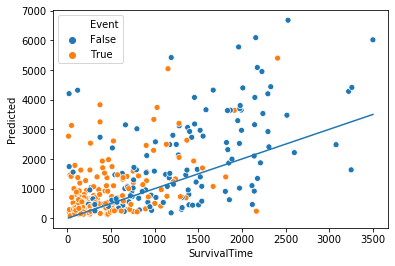

In [572]:
df = pd.concat([predicted_survival_time, output_train], axis=1, sort=False)
sns.scatterplot(x='SurvivalTime', y='Predicted', hue='Event', data=df)
print("n° of escape (Event = 0) : " + np.str(np.size(output_train[output_train["Event"]==0],0)) +
         " n° of deaths (Event = 1) : " + np.str(np.size(output_train[output_train["Event"]==1],0)))
sns.lineplot(x=predict_train_function[0].x, y=predict_train_function[0].x)

I know have one model that can work to predict survival times.

Because the source of the dataset can affect the output greatly I will try to cut my dataset in 2 and to consider two distinct models depending on whether the patient is from dataset l1 or l2 and see if they achieve better predictions by themselves.

In [588]:
features_train_set1, features_train_set2 = preprocessing_data(
    radiomics_train_ini, clinical_train_ini, scaler_radiomics, scaler_age, pearson_table_select.columns, True)

To ease the calcul, retrieval and plotting of predictions I create the following function.

In [800]:
def get_predictions(feature, target, model, fit=True):
    pred = model.predict(feature)
    ci = concordance_index_censored(target["Event"], target['SurvivalTime'], pred)
    print("CI = " + np.str(ci[0]))

    pred_fct = model.predict_survival_function(feature)
    pred_median = get_predict_time(pred_fct, feature, fit)
    df = pd.concat([pred_median, target], axis=1, sort=False)
    sns.scatterplot(x='SurvivalTime', y='Predicted', hue='Event', data=df)
    print("n° of escape (Event = 0) : " + np.str(np.size(target[target["Event"]==0],0)) +
         " n° of deaths (Event = 1) : " + np.str(np.size(target[target["Event"]==1],0)))
    sns.lineplot(x=pred_fct[0].x, y=pred_fct[0].x)
    return pred, pred_fct

[0.61871658 0.54335586 0.52909699]
CI = 0.6348779080945972
n° of escape (Event = 0) : 71 n° of deaths (Event = 1) : 128


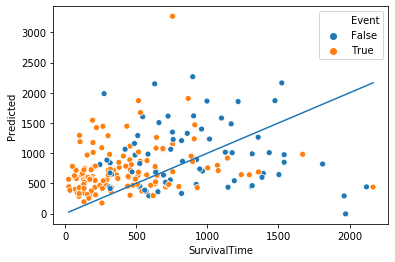

In [575]:
model_etimator_set1 = create_apply_model(estimator, features_train_set1, 
                                         output_train[clinical_train_ini['SourceDataset']=='l1'], 3)
pd.Series(model_etimator_set1.coef_, index=features_train_set1.columns)

predict_train_set1, predict_fct_set1 = get_predictions(
    features_train_set1, output_train[clinical_train_ini['SourceDataset']=='l1'], model_etimator_set1)

The graph shows the predicted survival times plotted against the actual survival time. The line means perfect equality between the two. The estimation of variance is large and the center of plotted data is located to the left of the line, so our predicted time might be biaised.

The correlation index is also smaller than the precedent model

[0.69204152 0.62289562 0.61611374]
CI = 0.7474374743747437
n° of escape (Event = 0) : 67 n° of deaths (Event = 1) : 34


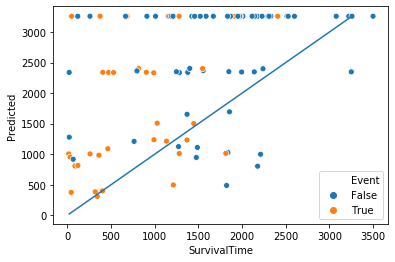

In [631]:
model_etimator_set2 = create_apply_model(estimator, features_train_set2, 
                                         output_train[clinical_train_ini['SourceDataset']=='l2'], 3)
pd.Series(model_etimator_set2.coef_, index=features_train_set2.columns)

predict_train_set2, predict_fct_set2 = get_predictions(
    features_train_set2, output_train[clinical_train_ini['SourceDataset']=='l2'], model_etimator_set2, False)

From the second dataset a lot of the predicted time reached the time limit, meaning that the predicted probability of survival was always above 0.5. It is interesting to see that this happened only for subjects among the second dataset. One of the main reason I see to this is the proportion of censored data in each subset : in the second dataset two third of the subjects escaped the study wheres in the first dataset only one third escaped it.

The correlation index is better than the last model. The reason I see are those maximum times: since the CI is calculated on the right ordering of valid pairs if two subjects have the same predicted time of 3500 days their order can be assessed as valid even if the information in it is false.

### CoxPH models on two separate subsets

One of the problems I'm seeing is the way I'm separating my dataset in two, I'm creating two different models but I use the standardization accross the complete table and I keep the same features from both. Since I want to consider two different models for the two subsets, I need to cut my data from the beginning and do the whole scaling, features selection and model fitting process. To make it easier for next tests I will create a pipeline of this process that can be used with variations.

In [705]:
def pipeline(radio, clini, out, idx_col, th, selectF = True):
    #normalize data
    scaler_rad = preprocessing.StandardScaler().fit(radio)
    radio_norm = radio.copy()
    radio_norm[radio_norm.columns] = scaler_rad.transform(radio[radio.columns])
    
    clini_norm = clini.copy()
    clini_norm['age'] = clini_norm.age.replace(
        np.NaN, np.median(clini['age'][~clini['age'].isnull()].values))
    scaler_a = preprocessing.StandardScaler().fit(clini_norm['age'].values.reshape(-1, 1))
    clini_norm['age'] = scaler_a.transform(clini_norm['age'].values.reshape(-1, 1))
  
    #select features  
    def select_features(feat, target, th):
        ps = pd.concat([feat, target], axis=1, sort=False).corr(method='pearson')
        i = ps[np.abs(ps.SurvivalTime) < th-0.01].index
        pss = ps.copy()
        pss = pss.drop(index = i, columns = i).drop(columns='SurvivalTime', axis=1)
        mask = np.sum(np.abs(pss[np.abs(pss)>0.95]))>=4.8
        return pss.drop(index = mask[mask==True].index, columns = mask[mask==True].index)
    if selectF:
        targ_un = out['SurvivalTime'][out['Event'] == 1]
        radio_un = radio[out['Event'] == 1]
        feat_col = select_features(radio_un, targ_un, th)
        feat = preprocessing_data(radio, clini, scaler_rad, scaler_a, feat_col.columns, idx_col)
    else:
        feat = preprocessing_data(radio, clini, scaler_rad, scaler_a, radio.columns, idx_col)
    
    return scaler_rad, scaler_a, feat

In [684]:
id_col_clini = (clinical_train_ini.columns == 'age') + (clinical_train_ini.columns == 'Nstage') + (clinical_train_ini.columns == 'Tstage') 

idx_col1 = clinical_train_ini['SourceDataset']=='l1'
rad1 = radiomics_train_ini[idx_col1]
cli1 = clinical_train_ini[idx_col1]
scaler_rad1, scaler_a1, features1 = pipeline(rad1, cli1, output_train[idx_col1], clinical_train_ini.columns[id_col_clini], 0.3)

idx_col2 = clinical_train_ini['SourceDataset']=='l2'
rad2 = radiomics_train_ini[idx_col2]
cli2 = clinical_train_ini[idx_col2]
scaler_rad2, scaler_a2, features2 = pipeline(rad2, cli2, output_train[idx_col2], clinical_train_ini.columns[id_col_clini], 0.25)

[0.63475936 0.55123874 0.55250836]
CI = 0.6194321604819586
n° of escape (Event = 0) : 71 n° of deaths (Event = 1) : 128


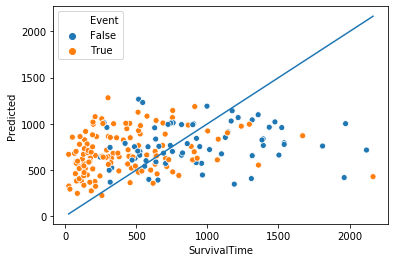

In [687]:
model_1 = create_apply_model(estimator, features1, 
                                         output_train[clinical_train_ini['SourceDataset']=='l1'], 3)
pd.Series(model_1.coef_, index=features1.columns)

predict_1, predict_fct_1 = get_predictions(
    features1, output_train[clinical_train_ini['SourceDataset']=='l1'], model_1)

[0.51903114 0.53872054 0.52606635]
CI = 0.6375563755637557
n° of escape (Event = 0) : 67 n° of deaths (Event = 1) : 34


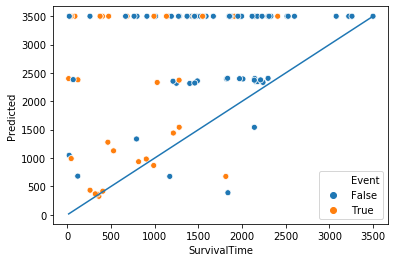

In [689]:
model_2 = create_apply_model(estimator, features2, 
                                         output_train[clinical_train_ini['SourceDataset']=='l2'], 3)
pd.Series(model_2.coef_, index=features2.columns)

predict_2, predict_fct_2 = get_predictions(
    features2, output_train[clinical_train_ini['SourceDataset']=='l2'], model_2, False)

The prediction still don't seem the best. But again the large amount (almost half) of censored data if our set leads to a lot of errors in prediction.

### Test of the model on uncensored data

In order to see how the censored data affect the model I'll try to apply the process (without subdividing into two datasets) to  only the uncensored data.

[0.58461538 0.4996501  0.65454545]
CI = 0.6386245010746086
n° of escape (Event = 0) : 0 n° of deaths (Event = 1) : 162


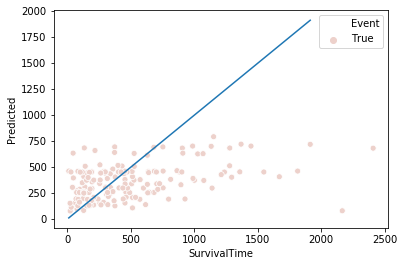

In [691]:
col_id = (clinical_train_ini.columns == 'age') + (clinical_train_ini.columns == 'Nstage') + (
    clinical_train_ini.columns == 'Tstage') + (clinical_train_ini.columns == 'SourceDataset')  


scaler_rad_uncensored, scaler_age_uncensored, features_uncensored = pipeline(radiomics_train_ini[output_train_ini['Event']==1],
                                             clinical_train_ini[output_train_ini['Event']==1],
                                             output_train[output_train_ini['Event']==1], 
                                             clinical_train_ini.columns[col_id], 0.3)

model_uncensored = create_apply_model(estimator, features_uncensored, 
                                         output_train[output_train_ini['Event']==1], 3)
pd.Series(model_uncensored.coef_, index=features_uncensored.columns)

predict_uncensored, predict_fct_uncensored = get_predictions(
    features_uncensored, output_train[output_train_ini['Event']==1], model_uncensored, False)

With this scenario the variance of the predicted times are greatly diminished but can maybe match better the reality. When dealing with survival times a small variation to the mean is preferred.

### CoxPH model with the features used in the baseline model
In the project description, a basaline model is presented, which is the CoxPH model with 8 features of interest. I will try to run my pipeline with this characteristics.

[0.69165294 0.62618015 0.70239371]
CI = 0.6884608085025622
n° of escape (Event = 0) : 138 n° of deaths (Event = 1) : 162


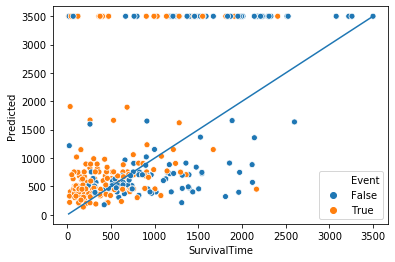

In [707]:
col_id = (clinical_train_ini.columns == 'Nstage')+ (clinical_train_ini.columns == 'SourceDataset')  

scaler_rad_baseline, scaler_age_baseline, features_baseline = pipeline(radiomics_train_ini, clinical_train_ini,
                                             output_train, clinical_train_ini.columns[col_id], 0.3, False) 
x = radiomics_train_ini.columns.drop(["original_shape_Sphericity",
    "original_shape_SurfaceVolumeRatio",
    "original_shape_Maximum3DDiameter",
    "original_firstorder_Entropy",
    "original_glcm_Id",
    "original_glcm_Idm"])
features_baseline = features_baseline.drop(x, axis=1)

model_baseline = create_apply_model(estimator, features_baseline, output_train, 3)
pd.Series(model_baseline.coef_, index=features_baseline.columns)

predict_baseline, predict_fct_baseline = get_predictions(features_baseline, output_train, model_baseline, False)

The results are quite similar to those of my other models, with still a huge error brought by the censored data.
The concordance index is a bit smaller than my first model tested.

## Validation on the test set and prediction

I will now retrieve the test set and fit my model on it to get the predicted times.

In [877]:
radiomics_test_ini = pd.read_csv('D:/Owkin_challenge/data_xtest/features/radiomics.csv', index_col=0, header=1)
clinical_test_ini = pd.read_csv('D:/Owkin_challenge/data_xtest/features/clinical_data.csv', index_col=0)

features_test_set1, features_test_set2 = preprocessing_data(
    radiomics_test_ini, clinical_test_ini, scaler_radiomics, scaler_age, pearson_table_select.columns, 
    clinical_test_ini[['age', 'Nstage', 'Tstage', 'SourceDataset']].columns, True)

def add_column_missing(ref, test, value):
    for col in ref.columns:
        if (col not in test.columns):
            test[col] = ref[col]
            test[col] = value
    testcop = test.copy()
    for col in test.columns:
        if (col not in ref.columns):
            testcop = testcop.drop(col, axis=1)
    return testcop

features_test_set1 = add_column_missing(features_train_set1, features_test_set1, 0)
features_test_set2 = add_column_missing(features_train_set2, features_test_set2, 0)    

In [878]:
predict_test_fct1 = model_etimator_set1.predict_survival_function(features_test_set1)
predict_test_median1 = get_predict_time(predict_test_fct1, features_test_set1)
predict_test_median1.describe()

count     85.0
mean     770.9
std      419.4
min      190.2
25%      432.2
50%      691.2
75%     1002.3
max     2190.2
Name: Predicted, dtype: float64

In [603]:
predict_test_fct2 = model_etimator_set2.predict_survival_function(features_test_set2)
predict_test_median2 = get_predict_time(predict_test_fct2, features_test_set2, False)
predict_test_median2.describe()

count     40.0
mean    2368.2
std     1123.7
min      327.5
25%     1253.6
50%     3259.0
75%     3259.0
max     3259.0
Name: Predicted, dtype: float64

With the second datasets, the predicted survival times don't seem accurate, this is due to the fact that our model was constructed on mostly uncensored data from which it is hard to concluded things. 

In [738]:
features_test = preprocessing_data(
    radiomics_test_ini, clinical_test_ini, scaler_radiomics, scaler_age, pearson_table_select.columns, 
    clinical_test_ini.columns.drop('Mstage', 'Histology'))
features_test = add_column_missing(features_train, features_test[features_train.columns], 0)

predict_test_fct = model_etimator.predict_survival_function(features_test)
predict_test_median = get_predict_time(predict_test_fct, features_test)
predict_test_median[predict_test_median>3500] = 3500 
predict_test_median = predict_test_median.rename(columns={'Predicted':'SurvivalTime'})

nan = np.empty(np.size(predict_test_median))
nan[:] = 'nan'
output_test = pd.DataFrame({'SurvivalTime':predict_test_median, 'Event':nan}, index=predict_test_median.index)
output_test

,SurvivalTime,Event
PatientID,,
13,839.0,nan
155,1964.0,nan
404,406.5,nan
407,766.0,nan
9,3500.0,nan
...,...,...
66,103.4,nan
132,1147.0,nan
169,2501.9,nan


In [739]:
output_test.to_csv(r'D:/Owkin_challenge/output_test.csv', na_rep='nan')

## Another try at a model, random forest

I managed to predict survival time with a performance of 0.6808 which is below the baseline. I want thus to create a new model whose predictions would be better. I thought of random forest.

For this I will use the features used in the baseline model.

In [831]:
from sklearn.model_selection import train_test_split
from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

radiomics_RTF = radiomics_train_ini[["original_shape_Sphericity",
    "original_shape_SurfaceVolumeRatio",
    "original_shape_Maximum3DDiameter",
    "original_firstorder_Entropy",
    "original_glcm_Id",
    "original_glcm_Idm"]]

#scale_RTF = preprocessing.StandardScaler().fit(radiomics_RTF)
radiomics_RTF_norm = radiomics_RTF.copy()
#radiomics_RTF_norm[radiomics_RTF_norm.columns] = scale_RTF.transform(
#    radiomics_RTF[radiomics_RTF.columns])

clinical_columns = ['SourceDataset', 'Nstage']
clinical_RTF = pd.get_dummies(clinical_train_ini[['SourceDataset', 'Nstage']], prefix=clinical_columns,
                              columns=clinical_columns, drop_first=True)
features_RTF = pd.concat([radiomics_RTF_norm, clinical_RTF], axis=1, sort=False).astype(np.float64)

output_train['SurvivalTime'] = output_train['SurvivalTime'].astype(np.float64)

random_state=20
X_train, X_test, y_train, y_test = train_test_split(features_RTF, output_train.to_records(index=False), 
                                                    test_size=0.25, random_state=random_state)

In [832]:
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, min_samples_leaf=15,
                     min_samples_split=10, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=20, verbose=0, warm_start=False)

In [833]:
rsf.score(X_test, y_test)

0.7003705664372684

In [813]:
def get_predict_time_RSF(predict, feature, model, fit=True):
    median_survival_time = np.zeros(np.size(predict,0))
    times = model.event_times_
    for i in range(np.size(predict,0)):
        if fit:
            sol = curve_fit(lambda t,a,b: a*np.log(b*t),  predict[i,:],  times, p0 = (-1000,1))
            median_survival_time[i] = np.log(0.5*sol[0][1])*sol[0][0]
        else:
            j=0
            while j<np.size(times) and predict[i,j]>0.5:
                j += 1
            if j < np.size(times):
                x = times[j-1]-times[j]
                y = predict[i,j-1]-predict[i,j]
                median_survival_time[i] = times[j-1]+(0.5-predict[i,j-1])*x/y
            else:
                median_survival_time[i] = times[j-1]
    pred = pd.Series(median_survival_time,name='Predicted', index=feature.index)
    return pred

def get_predictions_RSF(feature, target, model, fit=True):
    pred = model.predict(feature)
    ci = concordance_index_censored(target["Event"], target['SurvivalTime'], pred)
    print("CI = " + np.str(ci[0]))

    pred_fct = model.predict_survival_function(feature)
    pred_median = get_predict_time_RSF(pred_fct, feature, model, fit)
    df = pd.concat([pred_median, target], axis=1, sort=False)
    sns.scatterplot(x='SurvivalTime', y='Predicted', hue='Event', data=df)
    print("n° of escape (Event = 0) : " + np.str(np.size(target[target["Event"]==0],0)) +
         " n° of deaths (Event = 1) : " + np.str(np.size(target[target["Event"]==1],0)))
    sns.lineplot(x=model.event_times_, y=model.event_times_)
    return pred, pred_fct

CI = 0.7298190675017397
n° of escape (Event = 0) : 138 n° of deaths (Event = 1) : 162


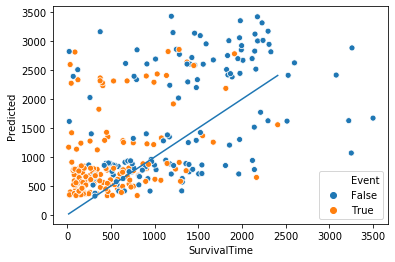

In [816]:
pred_RSF, pred_fct_RSF = get_predictions_RSF(features_RTF, output_train, rsf, True)

The concordance index seems quite good, but the predicted times are still quite higher than the actual ones. 
I will use this model to predict on my test set.

In [880]:
radiomics_test_RTF = radiomics_test_ini[["original_shape_Sphericity",
    "original_shape_SurfaceVolumeRatio",
    "original_shape_Maximum3DDiameter",
    "original_firstorder_Entropy",
    "original_glcm_Id",
    "original_glcm_Idm"]]

clinical_columns = ['SourceDataset', 'Nstage']
clinical_test_RTF = pd.get_dummies(clinical_test_ini[['SourceDataset', 'Nstage']], prefix=clinical_columns,
                              columns=clinical_columns, drop_first=True)
features_test_RTF = pd.concat([radiomics_test_RTF, clinical_test_RTF], axis=1, sort=False).astype(np.float64)


features_test_RTF = add_column_missing(features_RTF, features_test_RTF, 0)

predict_test_fct_RTF = rsf.predict_survival_function(features_test_RTF)
predict_test_median_RTF = get_predict_time_RSF(predict_test_fct_RTF, features_test_RTF, rsf)
predict_test_median_RTF[predict_test_median_RTF>3500] = 3500 
predict_test_median_RTF = predict_test_median_RTF.rename(columns={'Predicted':'SurvivalTime'})

nan = np.empty(np.size(predict_test_median_RTF))
nan[:] = 'nan'
output_test_RTF = pd.DataFrame({'SurvivalTime':predict_test_median_RTF, 'Event':nan}, index=predict_test_median_RTF.index)
output_test_RTF.describe()

,SurvivalTime,Event
count,125.0,0.0
mean,1218.8,nan
std,849.1,nan
min,316.0,nan
25%,583.4,nan
50%,835.6,nan
75%,1477.6,nan
max,3160.6,nan


In [882]:
output_test_RTF.to_csv(r'D:/Owkin_challenge/output_test_RSF.csv', na_rep='nan')

## Future perspectives

The CoxPH model gave a 0.68 concordance index and the Random Survival Foest a 0.67 concordance index on the test set which is slighty inferior to the baseline. With more time I would go over all choices and asumptions I made to improve my model.

I had to stop there my study of this problem due to lack of time but if I had had more time here are the directions I'd have liked to take :

- find a way to deal with the uncensored data problem, maybe dig deeper into the CoxPH model to see how those data are dealt with. From what I saw in the litterature the used datasets are usually bigger and have a smaller proportion of censored data (here we have almost half..)

- explore a bit more the random survival forest. I only had the time to implement a quick method to test this type of model but maybe going more into it could be interesting for the predictions.

This has been my first real confrontation with a machine learning problem, my knowledge of the field was only academical up to this point (classes followed) with only small exercices on basic datasets. It was very interesting and formative to dive into this medical machine learning problem. 
Working on this project gave me the will to continue to work on gathering knowledge and pratice over machine learning techniques to get more efficient and be able to extract insightful informations from data. 